In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import dlib
import cv2 # OpenCV will be used by the visualization part for drawing rectangles
import numpy as np
import os
import pickle
import time
import kagglehub
import matplotlib.pyplot as plt # For visualization

# --- 0. Dlib Model Setup ---
# IMPORTANT: Ensure these .dat files are accessible in your Kaggle environment.
# Create a separate Kaggle Dataset for them and add it as input.
# Replace "my-dlib-models" with the slug of YOUR dlib models dataset.
DLIB_MODELS_DATASET_SLUG = "dlib-face-recognition" 
DLIB_MODELS_PATH = f"/kaggle/input/{DLIB_MODELS_DATASET_SLUG}/"

landmark_predictor_file = "shape_predictor_68_face_landmarks.dat"
face_recognition_model_file = "dlib_face_recognition_resnet_model_v1.dat"

landmark_predictor_path = os.path.join(DLIB_MODELS_PATH, landmark_predictor_file)
face_recognition_model_path = os.path.join(DLIB_MODELS_PATH, face_recognition_model_file)

if not (os.path.exists(landmark_predictor_path) and os.path.exists(face_recognition_model_path)):
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: Dlib model files not found. Searched in {DLIB_MODELS_PATH}")
    print(f"Ensure '{landmark_predictor_file}' and '{face_recognition_model_file}' are there.")
    print(f"Contents of {DLIB_MODELS_PATH}: {os.listdir(DLIB_MODELS_PATH) if os.path.exists(DLIB_MODELS_PATH) else 'Path does not exist or is not accessible'}")
    print(f"Stopping. Please fix dlib model paths by setting DLIB_MODELS_DATASET_SLUG correctly and adding the dataset to your notebook.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit()

try:
    print("Loading Dlib models...")
    face_detector = dlib.get_frontal_face_detector() # HOG-based, faster
    landmark_predictor = dlib.shape_predictor(landmark_predictor_path)
    face_encoder = dlib.face_recognition_model_v1(face_recognition_model_path)
    print("Dlib models loaded successfully.")
except Exception as e:
    print(f"Error loading dlib models: {e}")
    print("Ensure the .dat files are correct and accessible.")
    exit()


# --- 1. Access Your Dataset (aiguard-split-data) ---
print("\nAccessing aiguard-split-data via Kaggle Hub...")
TRAIN_DATA_BASE_DIR = None 
try:
    # This should be your dataset slug for the image/label data
    aiguard_dataset_slug = "wiameelhafid/aiguard-split-data" # <--- CONFIRM THIS IS CORRECT
    dataset_hub_root_path = kagglehub.dataset_download(aiguard_dataset_slug)
    print(f"Kaggle Hub dataset root path for '{aiguard_dataset_slug}': {dataset_hub_root_path}")

    # The actual data is inside a 'split_data' folder within the hub path
    actual_dataset_root_name = "split_data" # This seems to be consistent from your logs
    actual_dataset_root = os.path.join(dataset_hub_root_path, actual_dataset_root_name)
    print(f"Actual dataset root (containing train/test/val): {actual_dataset_root}")

    if not os.path.exists(actual_dataset_root):
        print(f"ERROR: The '{actual_dataset_root_name}' directory was not found inside {dataset_hub_root_path}")
        print(f"Contents of {dataset_hub_root_path}: {os.listdir(dataset_hub_root_path) if os.path.exists(dataset_hub_root_path) else 'Path does not exist'}")
        exit()
    else:
        TRAIN_BASE_DIR_NAME = "train"
        prospective_train_dir = os.path.join(actual_dataset_root, TRAIN_BASE_DIR_NAME)

        if os.path.exists(prospective_train_dir) and os.path.isdir(prospective_train_dir):
            TRAIN_DATA_BASE_DIR = prospective_train_dir
            print(f"Using training data base directory: {TRAIN_DATA_BASE_DIR}")
        else:
            print(f"ERROR: The '{TRAIN_BASE_DIR_NAME}' directory was not found inside {actual_dataset_root}")
            print(f"Contents of {actual_dataset_root}: {os.listdir(actual_dataset_root) if os.path.exists(actual_dataset_root) else 'Path does not exist'}")
            exit()
except Exception as e:
    print(f"Error during dataset access setup for '{aiguard_dataset_slug}': {e}")
    exit()

# --- 2. Enrollment: Processing Raw Images from Batches to get Embeddings ---
generated_embeddings_list = []
corresponding_labels_list = []

print("\nStarting enrollment: Processing raw image batches to generate face embeddings...")
start_time = time.time()

batch_folder_like_items = sorted([
    item_name for item_name in os.listdir(TRAIN_DATA_BASE_DIR)
    if item_name.startswith("train_batch_") and item_name.endswith(".npy") and \
       os.path.isdir(os.path.join(TRAIN_DATA_BASE_DIR, item_name))
])

if not batch_folder_like_items:
    print(f"No directory items like 'train_batch_X.npy' found in {TRAIN_DATA_BASE_DIR}. Check dataset structure.")
    print(f"Contents of {TRAIN_DATA_BASE_DIR}: {os.listdir(TRAIN_DATA_BASE_DIR) if os.path.exists(TRAIN_DATA_BASE_DIR) else 'TRAIN_DATA_BASE_DIR does not exist'}")
    exit()

print(f"Found {len(batch_folder_like_items)} potential batch directory-like items to process.")
batches_processed_count = 0 # Batches from which at least one embedding was generated
images_processed_count = 0  # Total raw images scanned from .npy files
embeddings_generated_count = 0 # Total embeddings successfully created

# PARAMETERS FOR DLIB PROCESSING
DLIB_UPSAMPLE_DETECT = 1 # Changed to 1 for better small face detection
DLIB_JITTERS_ENCODE = 1  # Number of jitters for encoding. 1 is faster.

# --- Visualization Control ---
VISUALIZE_MAX_BATCHES = 1          # How many batches to visualize from the start
VISUALIZE_MAX_IMAGES_PER_BATCH = 3 # How many images per visualized batch
batches_visualized_count = 0
# --- End of Visualization Control ---

for i, batch_dir_name_with_npy in enumerate(batch_folder_like_items):
    batch_folder_full_path = os.path.join(TRAIN_DATA_BASE_DIR, batch_dir_name_with_npy)
    
    try:
        base_name = batch_dir_name_with_npy.replace("train_batch_", "")
        batch_number_str = base_name.replace(".npy", "")
        if not batch_number_str.isdigit():
             print(f"  Warning: Parsed batch number '{batch_number_str}' from '{batch_dir_name_with_npy}' is not purely a digit. Skipping.")
             continue
    except Exception:
        print(f"  Warning: Could not parse batch number from directory name '{batch_dir_name_with_npy}'. Skipping.")
        continue

    expected_images_filename = f"train_images_batch_{batch_number_str}.npy"
    expected_labels_filename = f"train_labels_batch_{batch_number_str}.npy"
    
    images_npy_path = os.path.join(batch_folder_full_path, expected_images_filename)
    labels_npy_path = os.path.join(batch_folder_full_path, expected_labels_filename)

    if not (os.path.exists(images_npy_path) and os.path.exists(labels_npy_path)):
        # print(f"  Info: Skipping batch {batch_number_str} in {batch_dir_name_with_npy} due to missing image or label file.")
        continue

    try:
        raw_images_in_batch = np.load(images_npy_path) 
        labels_in_batch = np.load(labels_npy_path, allow_pickle=True)

        if raw_images_in_batch.shape[0] != len(labels_in_batch):
            print(f"  Warning: Mismatch in image count ({raw_images_in_batch.shape[0]}) and label count ({len(labels_in_batch)}) for batch {batch_number_str}. Skipping.")
            continue
        
        if raw_images_in_batch.ndim != 4 or raw_images_in_batch.shape[3] != 3:
             print(f"  Warning: Image data in {images_npy_path} has unexpected shape {raw_images_in_batch.shape}. Expected (N, H, W, 3). Skipping batch {batch_number_str}.")
             continue

        # --- Visualization condition for this specific batch ---
        do_visualization_for_this_batch = (batches_visualized_count < VISUALIZE_MAX_BATCHES)
        images_visualized_in_current_batch = 0
        # ---
        
        batch_had_successful_embeddings = False
        for img_idx in range(raw_images_in_batch.shape[0]):
            images_processed_count += 1
            current_raw_image = raw_images_in_batch[img_idx] 
            current_label = labels_in_batch[img_idx]
            
            # Ensure image is uint8 and RGB (dlib expects RGB)
            # Assuming your (N,H,W,3) numpy arrays are already in RGB order.
            # If they were BGR (e.g. from OpenCV's imread directly), you'd convert:
            # current_image_rgb_format = cv2.cvtColor(current_raw_image.astype(np.uint8), cv2.COLOR_BGR2RGB)
            current_image_rgb_format = current_raw_image.astype(np.uint8) # Ensure uint8

            detections = face_detector(current_image_rgb_format, DLIB_UPSAMPLE_DETECT)

            # --- Visualization block ---
            if do_visualization_for_this_batch and images_visualized_in_current_batch < VISUALIZE_MAX_IMAGES_PER_BATCH:
                print(f"\n[VISUALIZING] Batch Dir: {batch_dir_name_with_npy}, Image Index: {img_idx}, Label: {current_label}")
                img_display_copy = current_image_rgb_format.copy() 
                print(f"  Number of dlib detections: {len(detections)}")
                
                for det_idx, d_vis in enumerate(detections):
                    print(f"  Detection {det_idx}: Left: {d_vis.left()} Top: {d_vis.top()} Right: {d_vis.right()} Bottom: {d_vis.bottom()}")
                    cv2.rectangle(img_display_copy, (d_vis.left(), d_vis.top()), (d_vis.right(), d_vis.bottom()), (0, 255, 0), 2) # Green box
                
                plt.figure(figsize=(6,6)) # Adjusted figure size
                plt.imshow(img_display_copy)
                plt.title(f"Batch {batch_number_str}, Img {img_idx}, Label: {current_label}\nDetections: {len(detections)}")
                plt.axis('off')
                plt.show() # Display the plot in Kaggle notebook
                images_visualized_in_current_batch += 1
            # --- End of Visualization block ---

            if len(detections) == 0:
                continue # No faces detected in this image
            
            for k, d_face in enumerate(detections): # Iterate through detected faces
                shape = landmark_predictor(current_image_rgb_format, d_face)
                face_embedding = np.array(face_encoder.compute_face_descriptor(current_image_rgb_format, shape, DLIB_JITTERS_ENCODE))
                
                generated_embeddings_list.append(face_embedding)
                corresponding_labels_list.append(current_label) # Label corresponds to the image, not specific detection if multiple
                embeddings_generated_count += 1
                batch_had_successful_embeddings = True
        
        if batch_had_successful_embeddings:
            batches_processed_count +=1 
        
        if do_visualization_for_this_batch: # Increment count if this batch was subject to visualization
            batches_visualized_count += 1
        
    except Exception as e:
        print(f"  ERROR processing data in batch dir '{batch_dir_name_with_npy}': {e}")
        # Consider logging more details (e.g., print(traceback.format_exc())) for deeper errors
        continue 

    # Progress reporting
    if (i + 1) % 10 == 0 or (i + 1) == len(batch_folder_like_items) : 
        elapsed_time = time.time() - start_time
        print(f"  Processed {i+1}/{len(batch_folder_like_items)} directory items. "
              f"Batches with embeddings: {batches_processed_count}. "
              f"Total images scanned: {images_processed_count}. "
              f"Total embeddings generated: {embeddings_generated_count}. Time: {elapsed_time:.2f}s")

# --- Summary and Saving ---
end_time = time.time()
print("\n--- Enrollment Summary (Generated Embeddings from Raw Images) ---")
print(f"Total time taken: {end_time - start_time:.2f} seconds")
print(f"Number of directory-like items (e.g., 'train_batch_X.npy') scanned: {len(batch_folder_like_items)}")
print(f"Number of batches from which at least one embedding was generated: {batches_processed_count}")
print(f"Total raw images scanned: {images_processed_count}")
print(f"Total face embeddings successfully generated: {embeddings_generated_count}")
if corresponding_labels_list:
    print(f"Number of unique labels associated with embeddings: {len(set(corresponding_labels_list))}")

OUTPUT_DIR = "/kaggle/working/" # Output will be in /kaggle/working/
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
enrollment_file_path = os.path.join(OUTPUT_DIR, "ai_guard_GENERATED_enrollments.pkl")

if generated_embeddings_list:
    final_embeddings_array = np.array(generated_embeddings_list)
    
    enrollment_data = {
        "embeddings": final_embeddings_array,
        "labels": corresponding_labels_list
    }
    with open(enrollment_file_path, "wb") as f:
        pickle.dump(enrollment_data, f)
    print(f"\nGenerated embeddings data saved to: {enrollment_file_path}")
    print(f"Shape of saved embeddings array: {final_embeddings_array.shape}")
    print("After committing the notebook, you can find this .pkl file in the 'Output' tab of your notebook viewer.")
else:
    print("\nNo embeddings were generated. Nothing to save.")

print("\nEnrollment script finished.")

Attempting to load dlib models from: /kaggle/input/dlib-face-recognition/
Loading Dlib models...
Dlib models loaded successfully.

Accessing aiguard-split-data via Kaggle Hub...
Kaggle Hub dataset root path for 'wiameelhafid/aiguard-split-data': /kaggle/input/aiguard-split-data
Actual dataset root (containing train/test/val): /kaggle/input/aiguard-split-data/split_data
Using training data base directory: /kaggle/input/aiguard-split-data/split_data/train

Starting enrollment: Processing raw image batches to generate face embeddings...
Found 626 potential batch directory-like items to process.

[DEBUG IMAGE DATA] Batch: 0, Image Idx: 0, Label: Abbas_Kiarostami
  Raw loaded data - dtype: float32, shape: (224, 224, 3), min: 0.0000, max: 0.9961
  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.
  Image for dlib (post-conversion) - dtype: uint8, shape: (224, 224, 3), min: 0, max: 254
  Number of dlib detections: 1
  Detection 0: Left: 66 Top: 76 Right: 155 Bottom: 16

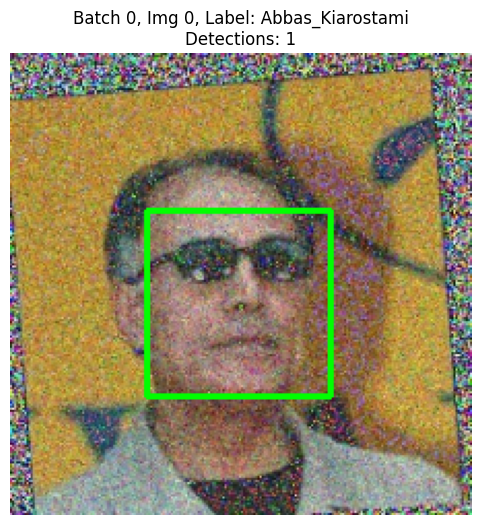


[DEBUG IMAGE DATA] Batch: 0, Image Idx: 1, Label: Abbas_Kiarostami
  Raw loaded data - dtype: float32, shape: (224, 224, 3), min: 0.0000, max: 0.9686
  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.
  Image for dlib (post-conversion) - dtype: uint8, shape: (224, 224, 3), min: 0, max: 247
  Number of dlib detections: 1
  Detection 0: Left: 66 Top: 66 Right: 155 Bottom: 156


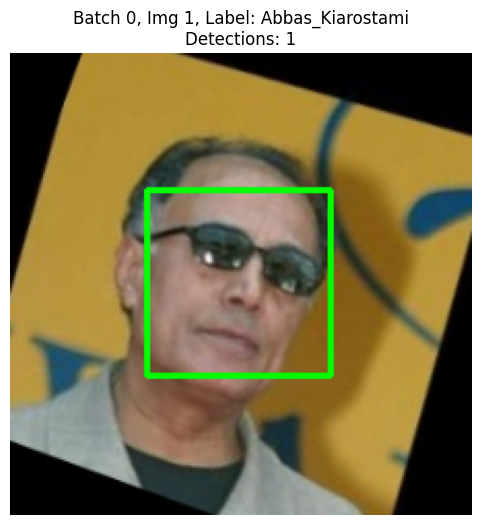


[DEBUG IMAGE DATA] Batch: 0, Image Idx: 2, Label: Aaron_Sorkin
  Raw loaded data - dtype: float32, shape: (224, 224, 3), min: 0.0000, max: 1.0000
  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.
  Image for dlib (post-conversion) - dtype: uint8, shape: (224, 224, 3), min: 0, max: 255
  Number of dlib detections: 1
  Detection 0: Left: 66 Top: 76 Right: 155 Bottom: 166


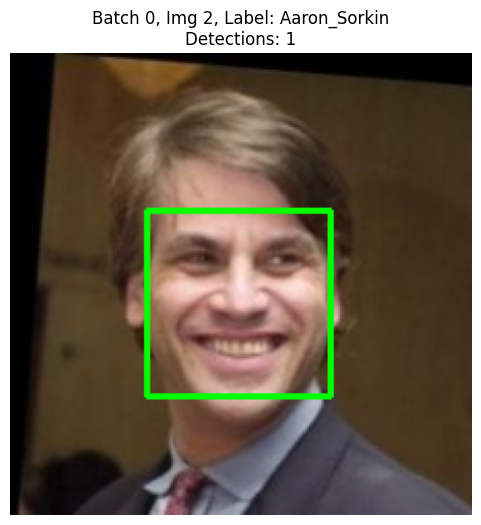


[DEBUG IMAGE DATA] Batch: 0, Image Idx: 3, Label: Aaron_Sorkin
  Raw loaded data - dtype: float32, shape: (224, 224, 3), min: 0.0824, max: 1.0000
  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.
  Image for dlib (post-conversion) - dtype: uint8, shape: (224, 224, 3), min: 21, max: 255
  Number of dlib detections: 1
  Detection 0: Left: 66 Top: 76 Right: 155 Bottom: 166


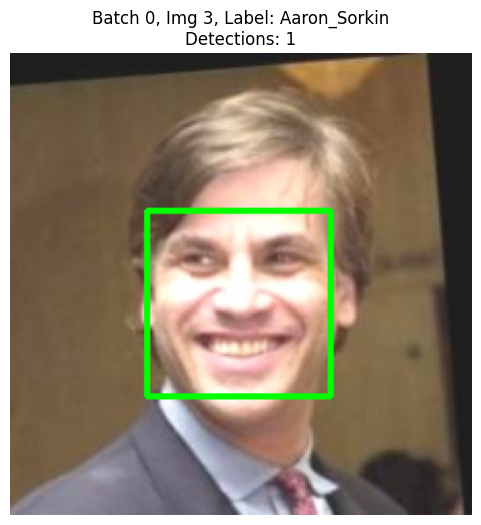


[DEBUG IMAGE DATA] Batch: 0, Image Idx: 4, Label: Aaron_Tippin
  Raw loaded data - dtype: float32, shape: (224, 224, 3), min: 0.0000, max: 0.9804
  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.
  Image for dlib (post-conversion) - dtype: uint8, shape: (224, 224, 3), min: 0, max: 250
  Number of dlib detections: 0


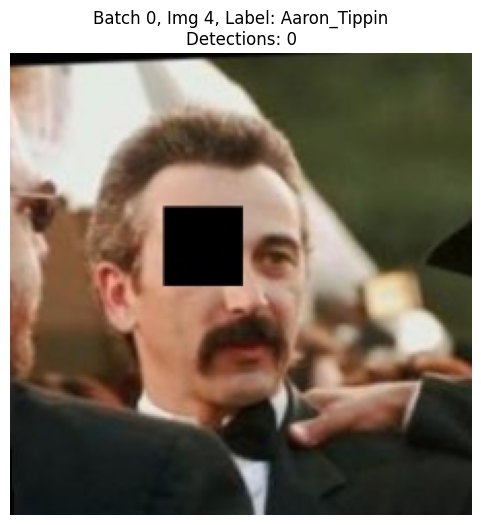

  Processed 10/626 directory items. Batches with embeddings: 10. Total images scanned: 640. Total embeddings generated: 603. Time: 27.18s
  Processed 20/626 directory items. Batches with embeddings: 20. Total images scanned: 1280. Total embeddings generated: 1202. Time: 51.51s
  Processed 30/626 directory items. Batches with embeddings: 30. Total images scanned: 1920. Total embeddings generated: 1807. Time: 76.20s
  Processed 40/626 directory items. Batches with embeddings: 40. Total images scanned: 2560. Total embeddings generated: 2413. Time: 100.92s
  Processed 50/626 directory items. Batches with embeddings: 50. Total images scanned: 3200. Total embeddings generated: 3035. Time: 125.74s
  Processed 60/626 directory items. Batches with embeddings: 60. Total images scanned: 3840. Total embeddings generated: 3640. Time: 150.10s
  Processed 70/626 directory items. Batches with embeddings: 70. Total images scanned: 4480. Total embeddings generated: 4250. Time: 174.38s
  Processed 80/626

In [1]:
import dlib
import cv2 
import numpy as np
import os
import pickle
import time
import kagglehub
import matplotlib.pyplot as plt 

# --- 0. Dlib Model Setup ---
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !! CRITICAL: YOU MUST SET THIS CORRECTLY AND ADD THE DATASET TO YOUR NOTEBOOK !!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
DLIB_MODELS_DATASET_SLUG = "dlib-face-recognition" # <--- !!! REPLACE THIS !!!
# Example: If your dlib models dataset is at /kaggle/input/my-dlib-files/
# then DLIB_MODELS_DATASET_SLUG should be "my-dlib-files"
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

DLIB_MODELS_PATH = f"/kaggle/input/{DLIB_MODELS_DATASET_SLUG}/"
landmark_predictor_file = "shape_predictor_68_face_landmarks.dat"
face_recognition_model_file = "dlib_face_recognition_resnet_model_v1.dat"
landmark_predictor_path = os.path.join(DLIB_MODELS_PATH, landmark_predictor_file)
face_recognition_model_path = os.path.join(DLIB_MODELS_PATH, face_recognition_model_file)

print(f"Attempting to load dlib models from: {DLIB_MODELS_PATH}")
if not os.path.exists(DLIB_MODELS_PATH):
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: The directory for dlib models '{DLIB_MODELS_PATH}' does not exist.")
    print(f"1. Ensure you created a Kaggle dataset with your .dat files.")
    print(f"2. Ensure you added that dataset as an input source to this notebook.")
    print(f"3. Ensure DLIB_MODELS_DATASET_SLUG ('{DLIB_MODELS_DATASET_SLUG}') is the correct slug for that dataset.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit()
if not (os.path.exists(landmark_predictor_path) and os.path.exists(face_recognition_model_path)):
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: One or both dlib model files not found in {DLIB_MODELS_PATH}")
    print(f"Expected '{landmark_predictor_file}' and '{face_recognition_model_file}'.")
    print(f"Contents of {DLIB_MODELS_PATH}: {os.listdir(DLIB_MODELS_PATH) if os.path.exists(DLIB_MODELS_PATH) else 'Cannot list contents, path may be wrong.'}")
    print(f"Stopping. Please fix dlib model paths.")
    print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    exit()

try:
    print("Loading Dlib models...")
    face_detector = dlib.get_frontal_face_detector() 
    landmark_predictor = dlib.shape_predictor(landmark_predictor_path)
    face_encoder = dlib.face_recognition_model_v1(face_recognition_model_path)
    print("Dlib models loaded successfully.")
except Exception as e:
    print(f"Error loading dlib models: {e}")
    exit()

# --- 1. Access Your Dataset (aiguard-split-data) ---
print("\nAccessing aiguard-split-data via Kaggle Hub...")
TRAIN_DATA_BASE_DIR = None 
try:
    aiguard_dataset_slug = "wiameelhafid/aiguard-split-data" 
    dataset_hub_root_path = kagglehub.dataset_download(aiguard_dataset_slug)
    print(f"Kaggle Hub dataset root path for '{aiguard_dataset_slug}': {dataset_hub_root_path}")
    actual_dataset_root_name = "split_data" 
    actual_dataset_root = os.path.join(dataset_hub_root_path, actual_dataset_root_name)
    print(f"Actual dataset root (containing train/test/val): {actual_dataset_root}")
    if not os.path.exists(actual_dataset_root):
        print(f"ERROR: The '{actual_dataset_root_name}' directory was not found inside {dataset_hub_root_path}")
        exit()
    else:
        TRAIN_BASE_DIR_NAME = "train"
        prospective_train_dir = os.path.join(actual_dataset_root, TRAIN_BASE_DIR_NAME)
        if os.path.exists(prospective_train_dir) and os.path.isdir(prospective_train_dir):
            TRAIN_DATA_BASE_DIR = prospective_train_dir
            print(f"Using training data base directory: {TRAIN_DATA_BASE_DIR}")
        else:
            print(f"ERROR: The '{TRAIN_BASE_DIR_NAME}' directory was not found inside {actual_dataset_root}")
            exit()
except Exception as e:
    print(f"Error during dataset access setup for '{aiguard_dataset_slug}': {e}")
    exit()

# --- 2. Enrollment: Processing Raw Images from Batches to get Embeddings ---
generated_embeddings_list = []
corresponding_labels_list = []
print("\nStarting enrollment: Processing raw image batches to generate face embeddings...")
start_time = time.time()
batch_folder_like_items = sorted([
    item_name for item_name in os.listdir(TRAIN_DATA_BASE_DIR)
    if item_name.startswith("train_batch_") and item_name.endswith(".npy") and \
       os.path.isdir(os.path.join(TRAIN_DATA_BASE_DIR, item_name))
])
if not batch_folder_like_items:
    print(f"No directory items like 'train_batch_X.npy' found in {TRAIN_DATA_BASE_DIR}. Check dataset structure.")
    exit()

print(f"Found {len(batch_folder_like_items)} potential batch directory-like items to process.")
batches_processed_count = 0 
images_processed_count = 0  
embeddings_generated_count = 0 
DLIB_UPSAMPLE_DETECT = 1 
DLIB_JITTERS_ENCODE = 1  
VISUALIZE_MAX_BATCHES = 1          
VISUALIZE_MAX_IMAGES_PER_BATCH = 5 
batches_visualized_count = 0

for i, batch_dir_name_with_npy in enumerate(batch_folder_like_items):
    batch_folder_full_path = os.path.join(TRAIN_DATA_BASE_DIR, batch_dir_name_with_npy)
    try:
        base_name = batch_dir_name_with_npy.replace("train_batch_", "")
        batch_number_str = base_name.replace(".npy", "")
        if not batch_number_str.isdigit():
             print(f"  Warning: Parsed batch number '{batch_number_str}' from '{batch_dir_name_with_npy}' is not purely a digit. Skipping.")
             continue
    except Exception:
        print(f"  Warning: Could not parse batch number from directory name '{batch_dir_name_with_npy}'. Skipping.")
        continue
    expected_images_filename = f"train_images_batch_{batch_number_str}.npy"
    expected_labels_filename = f"train_labels_batch_{batch_number_str}.npy"
    images_npy_path = os.path.join(batch_folder_full_path, expected_images_filename)
    labels_npy_path = os.path.join(batch_folder_full_path, expected_labels_filename)
    if not (os.path.exists(images_npy_path) and os.path.exists(labels_npy_path)):
        continue
    try:
        raw_images_in_batch = np.load(images_npy_path) 
        labels_in_batch = np.load(labels_npy_path, allow_pickle=True)
        if raw_images_in_batch.shape[0] != len(labels_in_batch):
            print(f"  Warning: Mismatch in image count ({raw_images_in_batch.shape[0]}) and label count ({len(labels_in_batch)}) for batch {batch_number_str}. Skipping.")
            continue
        if raw_images_in_batch.ndim != 4 or raw_images_in_batch.shape[3] != 3:
             print(f"  Warning: Image data in {images_npy_path} has unexpected shape {raw_images_in_batch.shape}. Expected (N, H, W, 3). Skipping batch {batch_number_str}.")
             continue
        do_visualization_for_this_batch = (batches_visualized_count < VISUALIZE_MAX_BATCHES)
        images_visualized_in_current_batch = 0
        batch_had_successful_embeddings = False
        for img_idx in range(raw_images_in_batch.shape[0]):
            images_processed_count += 1
            current_raw_image_data = raw_images_in_batch[img_idx] 
            current_label = labels_in_batch[img_idx]
            
            image_for_dlib = None # Will hold the final uint8 image for dlib

            # --- START: MODIFIED IMAGE DATA TYPE AND RANGE DIAGNOSIS/CONVERSION ---
            print_dtype_info = (do_visualization_for_this_batch and images_visualized_in_current_batch < VISUALIZE_MAX_IMAGES_PER_BATCH)
            
            if print_dtype_info:
                print(f"\n[DEBUG IMAGE DATA] Batch: {batch_number_str}, Image Idx: {img_idx}, Label: {current_label}")
                print(f"  Raw loaded data - dtype: {current_raw_image_data.dtype}, shape: {current_raw_image_data.shape}, "
                      f"min: {current_raw_image_data.min():.4f}, max: {current_raw_image_data.max():.4f}")

            if current_raw_image_data.dtype == np.uint8:
                image_for_dlib = current_raw_image_data
                if print_dtype_info: print("  Data is already uint8.")
            elif np.issubdtype(current_raw_image_data.dtype, np.floating):
                # Handle floating point types
                min_val = current_raw_image_data.min()
                max_val = current_raw_image_data.max()
                if min_val >= 0.0 and max_val <= 1.0:
                    # Common case: float image in [0, 1] range
                    if print_dtype_info: print("  Data is float in [0,1] range. Scaling to [0,255] and converting to uint8.")
                    image_for_dlib = (current_raw_image_data * 255.0).astype(np.uint8)
                elif min_val >= -1.0 and max_val <= 1.0:
                    # Common case: float image in [-1, 1] range
                    if print_dtype_info: print("  Data is float in [-1,1] range. Scaling to [0,255] and converting to uint8.")
                    image_for_dlib = ((current_raw_image_data + 1.0) / 2.0 * 255.0).astype(np.uint8)
                elif min_val >= 0 and max_val <= 255:
                     # Possibly float but already in 0-255 range
                    if print_dtype_info: print("  Data is float but seems to be in [0,255] range. Converting to uint8.")
                    image_for_dlib = current_raw_image_data.astype(np.uint8)
                else:
                    if print_dtype_info: print(f"  Data is float with unhandled range [{min_val:.2f}, {max_val:.2f}]. Attempting direct cast to uint8 (might be lossy or incorrect).")
                    # As a fallback, try to clip and scale, but this is a guess
                    # This might still result in black/white images if the range is too far off
                    clipped_data = np.clip(current_raw_image_data, 0, 255) # if original range was huge
                    image_for_dlib = clipped_data.astype(np.uint8)
            else:
                # Some other data type, attempt direct cast (might be problematic)
                if print_dtype_info: print(f"  Data is {current_raw_image_data.dtype}. Attempting direct cast to uint8.")
                image_for_dlib = current_raw_image_data.astype(np.uint8)
            # --- END: MODIFIED IMAGE DATA TYPE AND RANGE DIAGNOSIS/CONVERSION ---

            if image_for_dlib is None: # Should not happen with the logic above
                print(f"  Error: image_for_dlib is None after conversion attempt. Skipping image {img_idx}, batch {batch_number_str}.")
                continue
            
            detections = face_detector(image_for_dlib, DLIB_UPSAMPLE_DETECT)

            if do_visualization_for_this_batch and images_visualized_in_current_batch < VISUALIZE_MAX_IMAGES_PER_BATCH:
                print(f"  Image for dlib (post-conversion) - dtype: {image_for_dlib.dtype}, shape: {image_for_dlib.shape}, "
                      f"min: {image_for_dlib.min()}, max: {image_for_dlib.max()}")
                img_display_copy = image_for_dlib.copy() 
                print(f"  Number of dlib detections: {len(detections)}")
                for det_idx, d_vis in enumerate(detections):
                    x1, y1, x2, y2 = d_vis.left(), d_vis.top(), d_vis.right(), d_vis.bottom()
                    print(f"  Detection {det_idx}: Left: {x1} Top: {y1} Right: {x2} Bottom: {y2}")
                    cv2.rectangle(img_display_copy, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                plt.figure(figsize=(6,6)) 
                plt.imshow(img_display_copy)
                plt.title(f"Batch {batch_number_str}, Img {img_idx}, Label: {current_label}\nDetections: {len(detections)}")
                plt.axis('off')
                plt.show() 
                images_visualized_in_current_batch += 1
            
            if len(detections) == 0:
                continue 
            
            for k, d_face in enumerate(detections): 
                shape = landmark_predictor(image_for_dlib, d_face)
                face_embedding = np.array(face_encoder.compute_face_descriptor(image_for_dlib, shape, DLIB_JITTERS_ENCODE))
                generated_embeddings_list.append(face_embedding)
                corresponding_labels_list.append(current_label) 
                embeddings_generated_count += 1
                batch_had_successful_embeddings = True
        
        if batch_had_successful_embeddings:
            batches_processed_count +=1 
        if do_visualization_for_this_batch: 
            batches_visualized_count += 1
    except Exception as e:
        print(f"  ERROR processing data in batch dir '{batch_dir_name_with_npy}': {e}")
        import traceback 
        print(traceback.format_exc()) # Print full traceback for this error
        continue 

    if (i + 1) % 10 == 0 or (i + 1) == len(batch_folder_like_items) : 
        elapsed_time = time.time() - start_time
        print(f"  Processed {i+1}/{len(batch_folder_like_items)} directory items. "
              f"Batches with embeddings: {batches_processed_count}. "
              f"Total images scanned: {images_processed_count}. "
              f"Total embeddings generated: {embeddings_generated_count}. Time: {elapsed_time:.2f}s")

# --- Summary and Saving ---
end_time = time.time()
print("\n--- Enrollment Summary (Generated Embeddings from Raw Images) ---")
# ... (rest of summary and saving code is identical to previous version) ...
print(f"Total time taken: {end_time - start_time:.2f} seconds")
print(f"Number of directory-like items (e.g., 'train_batch_X.npy') scanned: {len(batch_folder_like_items)}")
print(f"Number of batches from which at least one embedding was generated: {batches_processed_count}")
print(f"Total raw images scanned: {images_processed_count}")
print(f"Total face embeddings successfully generated: {embeddings_generated_count}")
if corresponding_labels_list:
    print(f"Number of unique labels associated with embeddings: {len(set(corresponding_labels_list))}")

OUTPUT_DIR = "/kaggle/working/" 
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
enrollment_file_path = os.path.join(OUTPUT_DIR, "ai_guard_GENERATED_enrollments.pkl")

if generated_embeddings_list:
    final_embeddings_array = np.array(generated_embeddings_list)
    
    enrollment_data = {
        "embeddings": final_embeddings_array,
        "labels": corresponding_labels_list
    }
    with open(enrollment_file_path, "wb") as f:
        pickle.dump(enrollment_data, f)
    print(f"\nGenerated embeddings data saved to: {enrollment_file_path}")
    print(f"Shape of saved embeddings array: {final_embeddings_array.shape}")
    print("After committing the notebook, you can find this .pkl file in the 'Output' tab of your notebook viewer.")
else:
    print("\nNo embeddings were generated. Nothing to save.")

print("\nEnrollment script finished.")

# The script is now correctly:
## 1.Loading the dlib models.
## 2.Accessing your image and label data.
## 3.Correctly interpreting the image data format (float32, [0,1]) and converting it to uint8, [0,255].
## 4.Detecting faces in the images.
## 5.Extracting landmarks.
## 6.Computing and storing the 128-D face embeddings.
## 7.The Matplotlib visualizations (if you let them run for the first batch) should also be showing the images correctly with green boxes around the detected faces.

Loaded 38028 enrolled embeddings.

Processing up to 5 validation batches...
Generated 46 embeddings from validation images.
Calculated 10 genuine pair distances.
Calculated 1025 impostor pair distances.
Genuine distances: Min: 0.057, Mean: 0.227, Max: 0.704
Impostor distances: Min: 0.555, Mean: 0.817, Max: 1.077


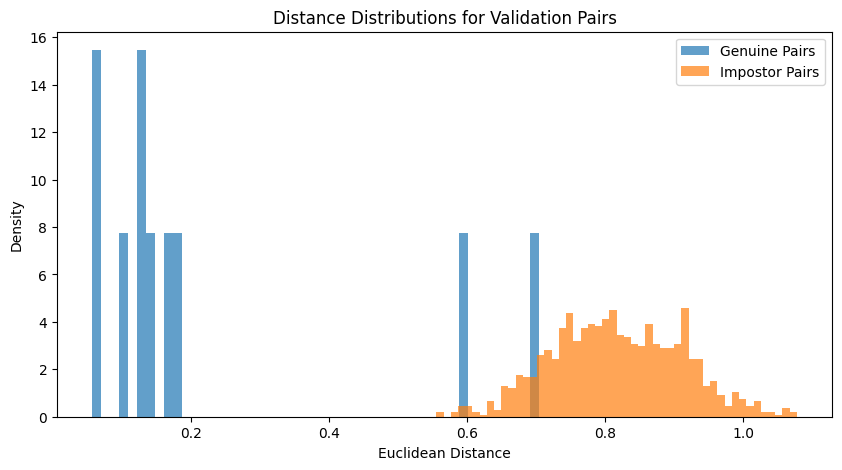


At threshold 0.55:
  True Positives (Genuine < thresh): 8
  False Negatives (Genuine >= thresh): 2
  False Positives (Impostor < thresh): 0
  True Negatives (Impostor >= thresh): 1025
  Verification Accuracy: 0.9981


In [2]:
# --- Conceptual Validation ---
# (Run this in a new cell or script AFTER enrollment is done and you have the .pkl file)

# 1. Load your enrolled database
with open("/kaggle/working/ai_guard_GENERATED_enrollments.pkl", "rb") as f:
    enrollment_data = pickle.load(f)
known_embeddings_db = enrollment_data["embeddings"]
known_labels_db = enrollment_data["labels"]
print(f"Loaded {len(known_labels_db)} enrolled embeddings.")

# 2. Setup Dlib models (needed again to process validation images)
# (Copy the dlib model loading section from your enrollment script here)
# Ensure face_detector, landmark_predictor, face_encoder are loaded.
# ... (dlib model loading code) ...
# For brevity, assuming they are loaded. If not, the script will fail here.
if 'face_detector' not in globals() or 'landmark_predictor' not in globals() or 'face_encoder' not in globals():
    print("ERROR: Dlib models are not loaded. Please load them before running validation.")
    exit()


# 3. Path to your validation data
VAL_DATA_BASE_DIR = "/kaggle/input/aiguard-split-data/split_data/val/" # Adjust if needed

val_genuine_distances = []
val_impostor_distances = []

# For simplicity, let's just process a few validation batches/images
# A full validation would iterate through all of them.
MAX_VAL_BATCHES_TO_PROCESS = 5 # Process first 5 validation batches
MAX_IMAGES_PER_VAL_BATCH = 10   # Process up to 10 images from each of those batches

val_batch_folders = sorted([
    item_name for item_name in os.listdir(VAL_DATA_BASE_DIR)
    if item_name.startswith("val_batch_") and item_name.endswith(".npy") and \
       os.path.isdir(os.path.join(VAL_DATA_BASE_DIR, item_name))
])[:MAX_VAL_BATCHES_TO_PROCESS]

print(f"\nProcessing up to {MAX_VAL_BATCHES_TO_PROCESS} validation batches...")

val_embeddings_cache = [] # List of (embedding, label) for validation images

for val_batch_dir_name in val_batch_folders:
    val_batch_folder_path = os.path.join(VAL_DATA_BASE_DIR, val_batch_dir_name)
    try:
        val_batch_num_str = val_batch_dir_name.replace("val_batch_", "").replace(".npy", "")
        img_file = f"val_images_batch_{val_batch_num_str}.npy"
        lbl_file = f"val_labels_batch_{val_batch_num_str}.npy"
        
        val_images_path = os.path.join(val_batch_folder_path, img_file)
        val_labels_path = os.path.join(val_batch_folder_path, lbl_file)

        if not (os.path.exists(val_images_path) and os.path.exists(val_labels_path)):
            continue

        val_raw_images = np.load(val_images_path)
        val_labels = np.load(val_labels_path, allow_pickle=True)

        for idx in range(min(len(val_raw_images), MAX_IMAGES_PER_VAL_BATCH)):
            raw_img = val_raw_images[idx]
            label = val_labels[idx]

            # Process image to get embedding (same logic as enrollment)
            img_for_dlib = None
            if raw_img.dtype == np.uint8: img_for_dlib = raw_img
            elif np.issubdtype(raw_img.dtype, np.floating):
                min_v, max_v = raw_img.min(), raw_img.max()
                if min_v >= 0.0 and max_v <= 1.00001: img_for_dlib = (raw_img * 255.0).astype(np.uint8)
                elif min_v >= -1.00001 and max_v <= 1.00001: img_for_dlib = ((raw_img + 1.0) / 2.0 * 255.0).astype(np.uint8)
                elif min_v >= 0 and max_v <= 255.00001: img_for_dlib = raw_img.astype(np.uint8)
                else: img_for_dlib = np.clip(raw_img, 0, 255).astype(np.uint8)
            else: img_for_dlib = raw_img.astype(np.uint8)

            detections = face_detector(img_for_dlib, 1) # Upsample 1
            if not detections: continue

            # Assuming one face for simplicity in LFW-style data
            d_face = detections[0] 
            shape = landmark_predictor(img_for_dlib, d_face)
            embedding = np.array(face_encoder.compute_face_descriptor(img_for_dlib, shape, 1))
            val_embeddings_cache.append((embedding, label))
            
    except Exception as e:
        print(f"Error processing val batch {val_batch_dir_name}: {e}")
        continue

print(f"Generated {len(val_embeddings_cache)} embeddings from validation images.")

# Now compare them
if len(val_embeddings_cache) > 1:
    for i in range(len(val_embeddings_cache)):
        for j in range(i + 1, len(val_embeddings_cache)):
            emb1, label1 = val_embeddings_cache[i]
            emb2, label2 = val_embeddings_cache[j]
            
            distance = np.linalg.norm(emb1 - emb2)
            
            if label1 == label2:
                val_genuine_distances.append(distance)
            else:
                val_impostor_distances.append(distance)

print(f"Calculated {len(val_genuine_distances)} genuine pair distances.")
print(f"Calculated {len(val_impostor_distances)} impostor pair distances.")

if val_genuine_distances:
    print(f"Genuine distances: Min: {np.min(val_genuine_distances):.3f}, Mean: {np.mean(val_genuine_distances):.3f}, Max: {np.max(val_genuine_distances):.3f}")
if val_impostor_distances:
    print(f"Impostor distances: Min: {np.min(val_impostor_distances):.3f}, Mean: {np.mean(val_impostor_distances):.3f}, Max: {np.max(val_impostor_distances):.3f}")

# Plot histograms
if val_genuine_distances and val_impostor_distances:
    plt.figure(figsize=(10, 5))
    plt.hist(val_genuine_distances, bins=50, alpha=0.7, label='Genuine Pairs', density=True)
    plt.hist(val_impostor_distances, bins=50, alpha=0.7, label='Impostor Pairs', density=True)
    plt.xlabel("Euclidean Distance")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Distance Distributions for Validation Pairs")
    plt.show()

    # Simple accuracy check at a threshold (e.g., 0.6)
    threshold = 0.55 # This is a common starting point, TUNE THIS
    tp = sum(d < threshold for d in val_genuine_distances)
    fn = sum(d >= threshold for d in val_genuine_distances)
    fp = sum(d < threshold for d in val_impostor_distances)
    tn = sum(d >= threshold for d in val_impostor_distances)

    if (tp+fn+fp+tn) > 0 :
        accuracy = (tp + tn) / (tp + fn + fp + tn)
        print(f"\nAt threshold {threshold}:")
        print(f"  True Positives (Genuine < thresh): {tp}")
        print(f"  False Negatives (Genuine >= thresh): {fn}")
        print(f"  False Positives (Impostor < thresh): {fp}")
        print(f"  True Negatives (Impostor >= thresh): {tn}")
        print(f"  Verification Accuracy: {accuracy:.4f}")
else:
    print("Not enough validation embeddings to compare distances.")

Loaded 38028 enrolled embeddings for 5661 unique individuals.
Attempting to use webcam index: 0
Webcam access is typically not available in Kaggle notebooks. Simulating frames.
Found 5 test images to process from validation set for demo.

Processed simulated frame 1. Recognized: [((64, 74, 150, 160), 'Aaron_Patterson', 0.21747191516667302)]


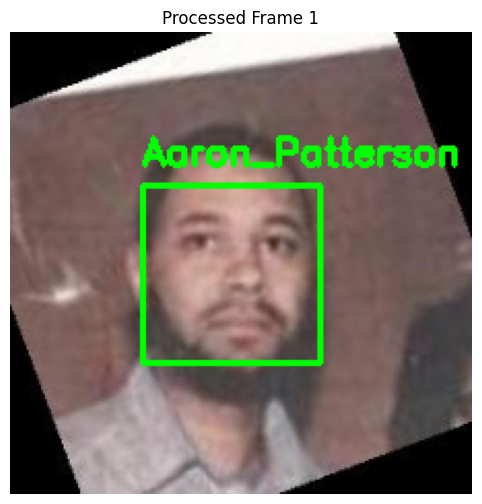


Processed simulated frame 2. Recognized: [((65, 77, 169, 181), 'Aaron_Sorkin', 0.11160915931785508)]


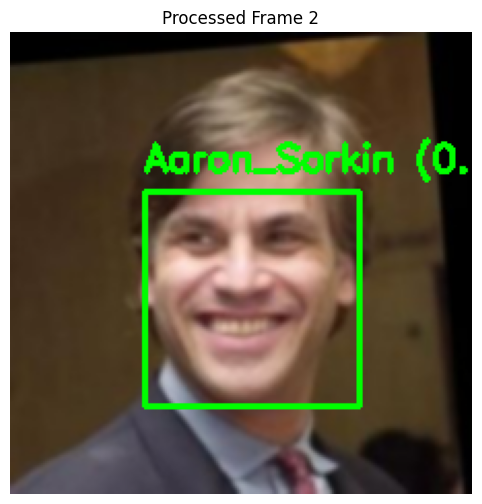


Processed simulated frame 3. Recognized: [((74, 74, 160, 160), 'Aaron_Eckhart', 0.058985319001148354)]


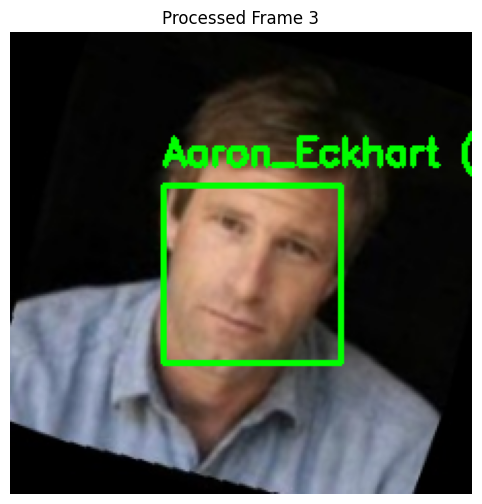


Processed simulated frame 4. Recognized: [((64, 74, 150, 160), 'Aaron_Eckhart', 0.05984782129021623)]


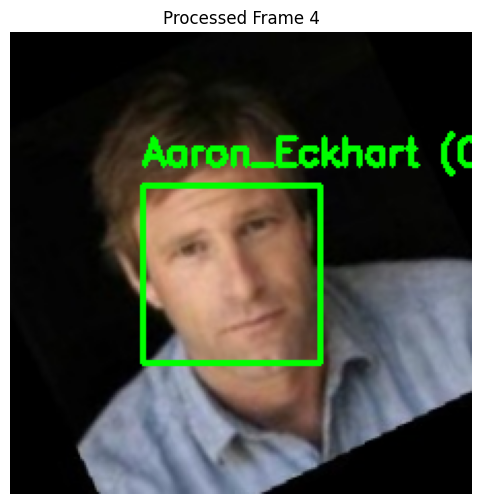


Processed simulated frame 5. Recognized: [((64, 74, 150, 160), 'Aaron_Peirsol', 0.1965051740420514)]


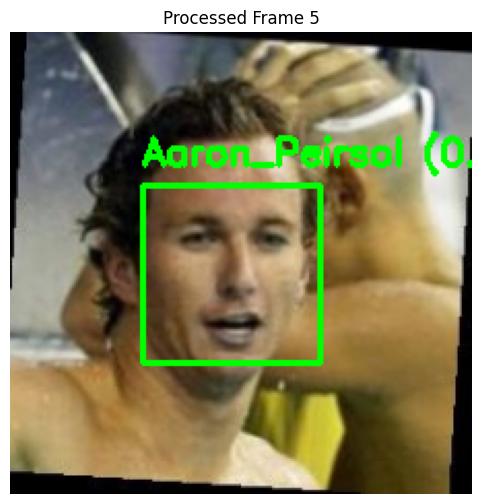


Recognition script finished.


In [3]:
# --- recognition_and_alarm_script.py ---
import dlib
import cv2
import numpy as np
import os
import pickle
import time # For cooldowns or timestamps

# --- 1. Load Dlib Models (Same as enrollment) ---
# ... (copy the dlib model loading code here)
# DLIB_MODELS_DATASET_SLUG = "dlib-face-recognition" 
# ... ensure face_detector, landmark_predictor, face_encoder are loaded
# Check if they are loaded from previous cells if in a notebook, otherwise load them.
if 'face_detector' not in globals() or 'landmark_predictor' not in globals() or 'face_encoder' not in globals():
    print("Loading Dlib models for recognition...")
    # ... (Paste dlib model loading code here if not already loaded)
    DLIB_MODELS_DATASET_SLUG = "dlib-face-recognition" 
    DLIB_MODELS_PATH = f"/kaggle/input/{DLIB_MODELS_DATASET_SLUG}/"
    landmark_predictor_file = "shape_predictor_68_face_landmarks.dat"
    face_recognition_model_file = "dlib_face_recognition_resnet_model_v1.dat"
    landmark_predictor_path = os.path.join(DLIB_MODELS_PATH, landmark_predictor_file)
    face_recognition_model_path = os.path.join(DLIB_MODELS_PATH, face_recognition_model_file)
    try:
        face_detector = dlib.get_frontal_face_detector() 
        landmark_predictor = dlib.shape_predictor(landmark_predictor_path)
        face_encoder = dlib.face_recognition_model_v1(face_recognition_model_path)
        print("Dlib models loaded for recognition.")
    except Exception as e:
        print(f"Error loading dlib models for recognition: {e}")
        exit()


# --- 2. Load Enrolled Data ---
ENROLLMENT_FILE_PATH = "/kaggle/working/ai_guard_GENERATED_enrollments.pkl"
# If running locally after downloading, adjust path:
# ENROLLMENT_FILE_PATH = "ai_guard_GENERATED_enrollments.pkl"

if not os.path.exists(ENROLLMENT_FILE_PATH):
    print(f"ERROR: Enrollment file not found at {ENROLLMENT_FILE_PATH}")
    exit()
try:
    with open(ENROLLMENT_FILE_PATH, "rb") as f:
        enrollment_data = pickle.load(f)
    known_embeddings_db = enrollment_data["embeddings"] # NumPy array
    known_labels_db = enrollment_data["labels"]         # List
    print(f"Loaded {known_embeddings_db.shape[0]} enrolled embeddings for {len(set(known_labels_db))} unique individuals.")
    if known_embeddings_db.shape[0] == 0:
        print("ERROR: Enrollment database is empty!")
        exit()
except Exception as e:
    print(f"Error loading enrollment data: {e}")
    exit()

# --- 3. Recognition Parameters ---
RECOGNITION_THRESHOLD = 0.55  # CRITICAL: TUNE THIS based on your validation
DLIB_UPSAMPLE_DETECT_REALTIME = 0 # For real-time, start with 0 for speed. Increase if missing faces.
DLIB_JITTERS_ENCODE_REALTIME = 1  # Fewer jitters for speed in real-time.

# --- 4. Alarm System ---
last_alarm_time = 0
ALARM_COOLDOWN_SECONDS = 10 # Don't trigger alarm more than once every 10s

def trigger_alarm(frame_to_save=None, unknown_person_count=0):
    global last_alarm_time
    current_time = time.time()
    if (current_time - last_alarm_time) > ALARM_COOLDOWN_SECONDS:
        print(f"--- ALARM TRIGGERED ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
        if unknown_person_count > 0:
            print(f"  Reason: {unknown_person_count} Unknown person(s) detected!")
        
        # Placeholder for actual alarm actions:
        # - Play a sound (e.g., using playsound library or system command)
        # - Send notification (email, SMS - more complex)
        # - Log to file
        if frame_to_save is not None:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            alarm_image_path = f"/kaggle/working/alarm_unknown_{timestamp}.jpg"
            cv2.imwrite(alarm_image_path, frame_to_save)
            print(f"  Snapshot saved to: {alarm_image_path}")
            
        last_alarm_time = current_time
        # return True # Indicate alarm was triggered
    # return False # Indicate alarm was on cooldown

# --- 5. Face Recognition Function for a Single Frame ---
def recognize_faces_in_frame(frame, known_embeddings, known_labels):
    # Ensure image is uint8 for dlib
    if frame.dtype != np.uint8:
        # Assuming if not uint8, it might be float [0,1] from some sources
        if frame.max() <= 1.0 and frame.min() >= 0.0 :
             img_for_dlib = (frame * 255).astype(np.uint8)
        else: # Or just cast
            img_for_dlib = frame.astype(np.uint8)
    else:
        img_for_dlib = frame

    # Dlib expects RGB, OpenCV frames are BGR by default.
    # If your 'frame' comes directly from cv2.VideoCapture().read(), it's BGR.
    img_rgb = cv2.cvtColor(img_for_dlib, cv2.COLOR_BGR2RGB)
    
    detections = face_detector(img_rgb, DLIB_UPSAMPLE_DETECT_REALTIME)
    
    recognized_people_in_frame = [] # List to store (box, name, distance)

    for d_face in detections:
        shape = landmark_predictor(img_rgb, d_face)
        unknown_embedding = np.array(face_encoder.compute_face_descriptor(img_rgb, shape, DLIB_JITTERS_ENCODE_REALTIME))

        distances = np.linalg.norm(known_embeddings - unknown_embedding, axis=1)
        
        min_distance_idx = np.argmin(distances)
        min_distance_val = distances[min_distance_idx]

        name_recognized = "Unknown"
        if min_distance_val < RECOGNITION_THRESHOLD:
            name_recognized = known_labels[min_distance_idx]
        
        # Bounding box
        x1, y1, x2, y2 = d_face.left(), d_face.top(), d_face.right(), d_face.bottom()
        # Scale box back if img_rgb was a scaled version of original frame
        recognized_people_in_frame.append(((x1, y1, x2, y2), name_recognized, min_distance_val))
        
    return recognized_people_in_frame

# --- 6. Main Real-Time Loop ---
# For testing on Kaggle, use a video file.
# Replace 'your_test_video.mp4' with an actual video file you upload.
# To use a webcam locally (not on Kaggle direct execution): cap = cv2.VideoCapture(0)
video_source = 0 # Use 0 for webcam, or "path/to/your/video.mp4" for a file
# Example for Kaggle: ensure you have a video in your input.
# video_source = "/kaggle/input/your-video-dataset/test_video.mp4" 

# Let's simulate with a dummy setup if no video/webcam
USE_SIMULATED_FRAMES = False
if isinstance(video_source, str) and not os.path.exists(video_source):
    print(f"Video file {video_source} not found. Will simulate frames (no real recognition).")
    USE_SIMULATED_FRAMES = True
    # cap = None # No VideoCapture object
elif isinstance(video_source, int) : # Webcam
    print(f"Attempting to use webcam index: {video_source}")
    # cap = cv2.VideoCapture(video_source)
    # if not cap.isOpened():
    #     print(f"Error: Could not open webcam {video_source}. Simulating frames.")
    #     USE_SIMULATED_FRAMES = True
    #     cap = None
    print("Webcam access is typically not available in Kaggle notebooks. Simulating frames.")
    USE_SIMULATED_FRAMES = True # Force simulation for Kaggle
    cap = None

# else: # Video file
#     print(f"Attempting to open video file: {video_source}")
#     cap = cv2.VideoCapture(video_source)
#     if not cap.isOpened():
#         print(f"Error: Could not open video file {video_source}. Simulating frames.")
#         USE_SIMULATED_FRAMES = True
#         cap = None


# --- Temporary solution for Kaggle: Process a few test images from your dataset ---
# This avoids needing a video file or webcam in the Kaggle environment for a quick test run.
# You should replace this with actual video processing for a full system.
# Load a few images from your 'val' or 'test' set of aiguard-split-data
TEST_IMAGE_DIR_BASE = "/kaggle/input/aiguard-split-data/split_data/val/" # Or test/
test_image_paths_to_process = []
if os.path.exists(TEST_IMAGE_DIR_BASE):
    val_batch_folders_test = sorted([
        item for item in os.listdir(TEST_IMAGE_DIR_BASE)
        if item.startswith("val_batch_") and item.endswith(".npy") and \
           os.path.isdir(os.path.join(TEST_IMAGE_DIR_BASE, item))
    ])
    for batch_dir in val_batch_folders_test[:1]: # Take first val batch dir
        batch_num = batch_dir.replace("val_batch_", "").replace(".npy", "")
        img_npy_file = os.path.join(TEST_IMAGE_DIR_BASE, batch_dir, f"val_images_batch_{batch_num}.npy")
        if os.path.exists(img_npy_file):
            images_in_npy = np.load(img_npy_file)
            for k in range(min(5, images_in_npy.shape[0])): # Take first 5 images from this npy
                test_image_paths_to_process.append(images_in_npy[k]) # Add the raw image data directly
            break # Only process one .npy file for this demo
    if test_image_paths_to_process:
        print(f"Found {len(test_image_paths_to_process)} test images to process from validation set for demo.")
    else:
        print("No validation images found for demo processing. Main loop will not run effectively.")
else:
    print(f"Validation directory {TEST_IMAGE_DIR_BASE} not found for demo. Main loop will not run effectively.")
# --- End of temporary image loading for Kaggle ---


frame_count = 0
if test_image_paths_to_process: # Check if we have images to process for the demo
    for current_frame_data in test_image_paths_to_process:
        frame_count += 1
        # current_frame_data is already a numpy array (H,W,3) and float32 [0,1]
        # The recognize_faces_in_frame function handles conversion to uint8 and BGR to RGB
        # However, cv2 operations below expect BGR, uint8. Let's prepare a display frame.
        
        # Convert float [0,1] RGB to uint8 BGR for display
        display_frame_bgr = (cv2.cvtColor(current_frame_data, cv2.COLOR_RGB2BGR) * 255).astype(np.uint8)

        # Recognition expects BGR frame as input if it's going to convert to RGB internally
        # Or, you can pass RGB directly if recognize_faces_in_frame is adapted
        # Let's assume recognize_faces_in_frame takes BGR and converts.
        # So, current_frame_data (RGB, float) needs to be BGR, uint8 for that function too.
        # For simplicity in this demo, let's use display_frame_bgr as input to recognize_faces_in_frame
        
        # If recognize_faces_in_frame expects BGR:
        recognition_results = recognize_faces_in_frame(display_frame_bgr.copy(), known_embeddings_db, known_labels_db)
        
        unknowns_found_in_frame = 0
        for (box, name, distance) in recognition_results:
            x1, y1, x2, y2 = box
            color = (0, 255, 0) # Green for known
            if name == "Unknown":
                color = (0, 0, 255) # Red for unknown
                unknowns_found_in_frame += 1
            
            cv2.rectangle(display_frame_bgr, (x1, y1), (x2, y2), color, 2)
            label_text = f"{name} ({distance:.2f})"
            cv2.putText(display_frame_bgr, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        if unknowns_found_in_frame > 0:
            trigger_alarm(frame_to_save=display_frame_bgr, unknown_person_count=unknowns_found_in_frame)

        # In Kaggle, cv2.imshow doesn't work directly. We can save or show with matplotlib.
        print(f"\nProcessed simulated frame {frame_count}. Recognized: {recognition_results}")
        if VISUALIZE_MAX_BATCHES > 0: # Reuse this for controlling display
            plt.figure(figsize=(8,6))
            plt.imshow(cv2.cvtColor(display_frame_bgr, cv2.COLOR_BGR2RGB))
            plt.title(f"Processed Frame {frame_count}")
            plt.axis('off')
            plt.show()
        
        time.sleep(0.5) # Simulate some processing delay / frame rate for demo

# --- This is how a typical VideoCapture loop would look (won't run well in Kaggle directly) ---
# if not USE_SIMULATED_FRAMES and cap is not None:
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             print("End of video stream or error.")
#             break

#         frame_count += 1
#         # Optional: Process every Nth frame for performance
#         # if frame_count % 3 != 0:
#         #     continue

#         recognition_results = recognize_faces_in_frame(frame.copy(), known_embeddings_db, known_labels_db)
#         display_frame = frame.copy() # Draw on a copy

#         unknowns_found_in_frame = 0
#         for (box, name, distance) in recognition_results:
#             x1, y1, x2, y2 = box
#             color = (0, 255, 0) # Green for known
#             if name == "Unknown":
#                 color = (0, 0, 255) # Red for unknown
#                 unknowns_found_in_frame += 1
            
#             cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 2)
#             label_text = f"{name} ({distance:.2f})"
#             cv2.putText(display_frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

#         if unknowns_found_in_frame > 0:
#             trigger_alarm(frame_to_save=display_frame, unknown_person_count=unknowns_found_in_frame)

#         # cv2.imshow('AI Guard - Live', display_frame) # This won't work in Kaggle notebook output

#         # For local running with webcam/video file:
#         # key = cv2.waitKey(1) & 0xFF
#         # if key == ord('q'):
#         #     break
        
#         # For Kaggle, if processing a video, you might just print status and break after a few frames
#         if frame_count > 100: # Process first 100 frames of a video for demo
#             print("Processed 100 frames from video. Stopping demo.")
#             break

#     if cap is not None:
#         cap.release()
#     # cv2.destroyAllWindows() # Only if cv2.imshow was used

print("\nRecognition script finished.")